# 10.06 ANN Usage

Previously we saw a more-or-less real problem where we performed face identification with the LFW dataset.
This is a quite complex dataset but has a good number of instances.
A neural network has a chance of performing a good-enough classification.

![Masks](ol-masks.svg)

<div style="text-align:right;"><sup>ol-masks.svg</sup></div>

We get the labeled faces in the wild dataset and many of the model
evaluation tools we saw.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
faces = fetch_lfw_people(min_faces_per_person=50)
faces.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Jacques Chirac',
       'Jean Chretien', 'John Ashcroft', 'Junichiro Koizumi',
       'Serena Williams', 'Tony Blair'], dtype='<U17')

To save computations - and time - we will perform PCA just once, on the full set.

A complete procedure will need to be careful to not taint the PCA with the test set.
NNs in `sklearn` are quite slow to train and a grid search will train many of them.
We note that in a real world problem we'd need to do the PCA as part of the
model selection but perform it on the full dataset to save presentation time.

In [2]:
pca = PCA(n_components=128)
faces_pca = pca.fit_transform(faces.data)
xtrain, xtest, ytrain, ytest = train_test_split(faces_pca, faces.target, test_size=0.2)

The hyperparameters are tuned on the training set only.
This is the most important concept in ML, therefore we will keep repeating it.

A NN has many hyperparameters to tune.
Notably, the hidden layer sizes have an infinity of tunable possibilities
as we can add and remove layers at will.
We force the learning rate 

In [3]:
net = MLPClassifier(hidden_layer_sizes=(300,), alpha=0.001,
                    tol=0.01, max_iter=100, solver='sgd')
param_dict = {
    'alpha': [0.01, 0.1, 1.0],
    'tol': [0.001, 0.01],
}
grid = GridSearchCV(net, param_dict, cv=5)
grid.fit(xtrain, ytrain)
grid.best_estimator_, grid.best_score_

(MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(300,), learning_rate='constant',
               learning_rate_init=0.001, max_fun=15000, max_iter=100,
               momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
               power_t=0.5, random_state=None, shuffle=True, solver='sgd',
               tol=0.001, validation_fraction=0.1, verbose=False,
               warm_start=False),
 0.7772273092369478)

This is a reasonable network, with 300 neurons in the hidden layer.
And the score is reasonable.
But the full report is what we should look at.

In [4]:
y_hat = grid.predict(xtest)
print(classification_report(ytest, y_hat, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.73      0.67        11
     Colin Powell       0.79      0.81      0.80        42
  Donald Rumsfeld       0.75      0.73      0.74        33
    George W Bush       0.88      0.92      0.90       110
Gerhard Schroeder       0.80      0.47      0.59        17
      Hugo Chavez       0.92      0.85      0.88        13
   Jacques Chirac       0.36      0.50      0.42         8
    Jean Chretien       1.00      0.67      0.80        12
    John Ashcroft       0.62      0.62      0.62         8
Junichiro Koizumi       0.92      0.79      0.85        14
  Serena Williams       0.69      0.64      0.67        14
       Tony Blair       0.63      0.73      0.68        30

         accuracy                           0.79       312
        macro avg       0.75      0.70      0.72       312
     weighted avg       0.80      0.79      0.79       312



And the confusion matrix to understand misclassification.

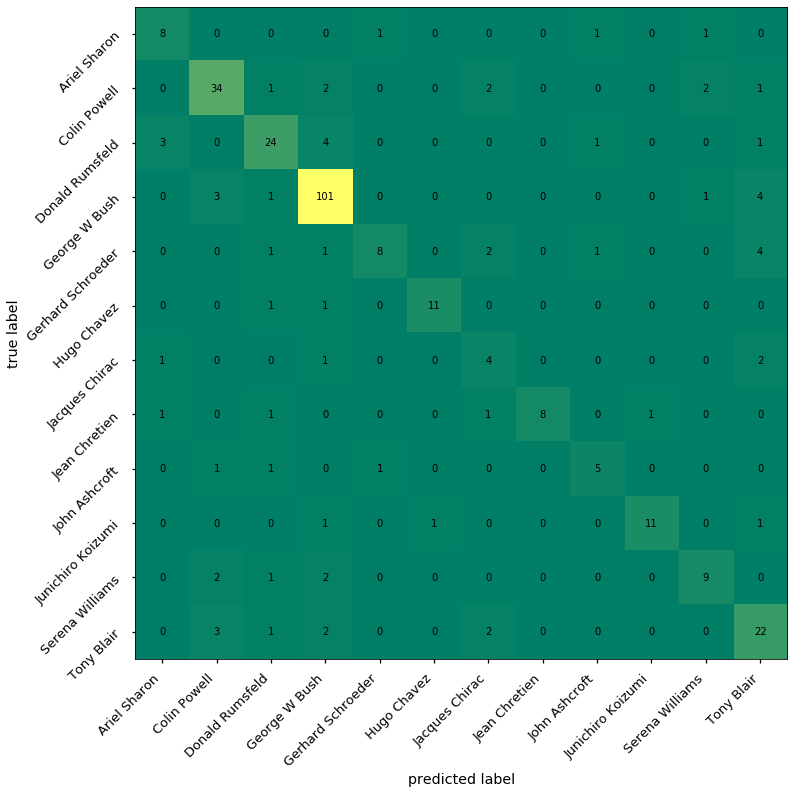

In [5]:
mat = confusion_matrix(ytest, y_hat)
fig, ax = plt.subplots(figsize=(12, 12))
cax = ax.matshow(mat, cmap='summer')
ticks = np.arange(0,len(faces.target_names))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(faces.target_names, rotation=45, ha='right')
ax.set_yticklabels(faces.target_names, rotation=45, ha='right')
ax.set_ylabel('true label')
ax.set_xlabel('predicted label')
ax.xaxis.set_ticks_position('bottom')

for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        ax.text(j, i, mat[i, j], ha='center', va='center')

By now we are rather used to check the reportand the confusion matrix,
for example, we can see the main diagonal forming in the confusion
matrix as a good sign of classification performance.
The NN performs reasonably and we did not even attempt to tune half
of all its hyperparameters.
That said, the number of hyperparameters is at the same time a strength
and a weakness of NNs.
SGD training uses a lot of randomness, and some hyperparameter tuning
may react badly to randomness.

Let's try to train networks of different sizes,
i.e. using the number of neurons in the hidden layer as a tunable hyperparameter.
We will train each size of the network twice,
so we can be confident that certain scores are not due to chance.
Several of these NNs may not converge within `max_iter=100` and give a warning.
That is fine, we want to find out the differences in how these NNs may behave.

In [6]:
sizes = [10, 30, 60, 100, 200, 300, 600, 900]
scores1 = []
scores2 = []
for size in sizes:
    for s in [scores1, scores2]:
        print('Trianing net of size', size)
        net = MLPClassifier(hidden_layer_sizes=(size,),
                            alpha=0.001, max_iter=100, solver='sgd')
        net.fit(xtrain, ytrain)
        score = net.score(xtest, ytest)
        s.append(score)

Trianing net of size 10
Trianing net of size 10


/home/grochmal/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trianing net of size 30
Trianing net of size 30
Trianing net of size 60
Trianing net of size 60
Trianing net of size 100
Trianing net of size 100
Trianing net of size 200
Trianing net of size 200
Trianing net of size 300
Trianing net of size 300
Trianing net of size 600
Trianing net of size 600
Trianing net of size 900
Trianing net of size 900


And let's have a look how the scores of all these different networks look.
This graph is likely to be quite different every time we retrain our
set of NNs of different size.

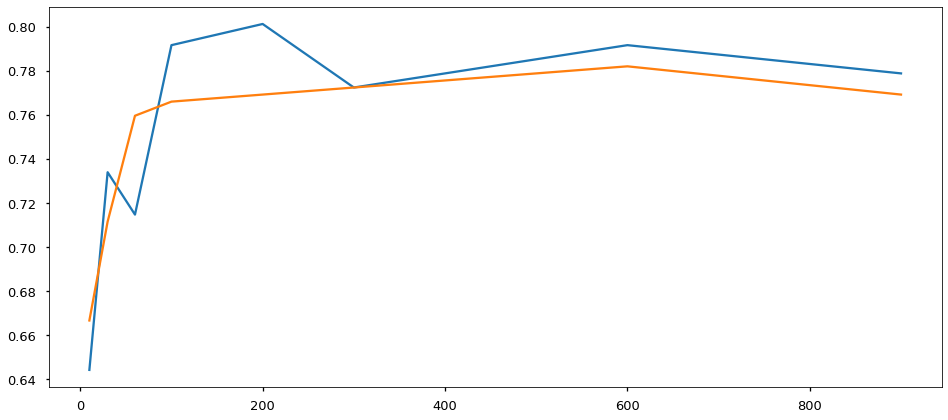

In [7]:
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(sizes, scores1)
ax.plot(sizes, scores2);

There is a good deal of randomness in NN training but we can say that around 300
neurons (perceptrons) in the hidden layer we reached some form of plateau in accuracy score.
The number of neurons in a layer can be used as a hyperparameter alright,
and should be tuned with a grid search.
Different layers in the network may be tuned in size independently,
the computational effort to train a network can be very big.